In [61]:
import pandas as pd

In [62]:
datambg = pd.read_csv("datalabel/mbglabel.csv")

In [63]:
datasarc = pd.read_csv("datalabel/sarcasticlabel.csv")

In [64]:
datatrainmix = pd.concat([datambg, datasarc], ignore_index=True)

In [65]:
datatrainmix.head()

,steming_data,Sentiment
0,makan siang gratis mending,Positif
1,bela mbak bias sekolah makan siang gratis pas ...,Positif
2,anggar dituruninnya ngopernya blog ya dicicipi...,Positif
3,karyawan industri cikarang makan siang jemput ...,Positif
4,ambil abang ya makan siang gratis ya abang rol...,Positif


C:\Users\UMMY\AppData\Local\Temp\ipykernel_18120\3459282689.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=sentiment_count.index, y=sentiment_count.values, palette='pastel')


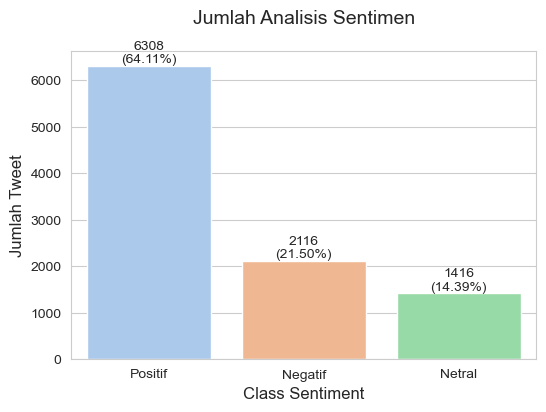

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

sentiment_count = datatrainmix['Sentiment'].value_counts()
sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(6, 4))
ax = sns.barplot(x=sentiment_count.index, y=sentiment_count.values, palette='pastel')
plt.title('Jumlah Analisis Sentimen', fontsize=14, pad=20)
plt.xlabel('Class Sentiment', fontsize=12)
plt.ylabel('Jumlah Tweet', fontsize=12)

total = len(datatrainmix['Sentiment'])

for i, count in enumerate(sentiment_count.values):
    percentage = f'{100 * count / total:.2f}%'
    ax.text(i, count + 0.10, f'{count}\n({percentage})', ha='center', va='bottom')

plt.show()

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

cleaned_data = datatrainmix.dropna(subset=['steming_data'])

X = cleaned_data['steming_data']
y = cleaned_data['Sentiment']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Jumlah data latih:", len(X_train))
print("Jumlah data uji:", len(X_test))
print('===========================')

vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

X_train_vec.shape, X_test_vec.shape

Jumlah data latih: 7872
Jumlah data uji: 1968


((7872, 11858), (1968, 11858))

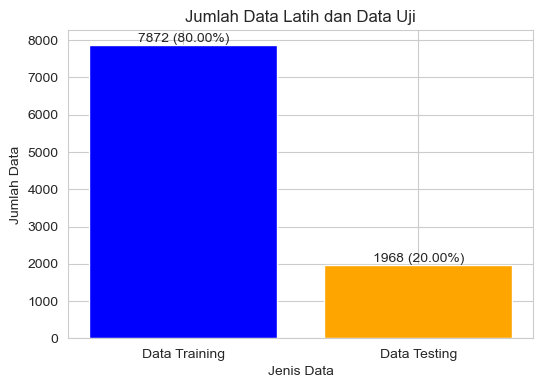

In [68]:
import matplotlib.pyplot as plt


train_size = len(X_train)
test_size = len(X_test)

plt.figure(figsize=(6, 4))
bars = plt.bar(['Data Training', 'Data Testing'], [train_size, test_size], color=['blue', 'orange'])

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height} ({height / (train_size + test_size) * 100:.2f}%)',
             ha='center', va='bottom')

plt.title('Jumlah Data Latih dan Data Uji')
plt.xlabel('Jenis Data')
plt.ylabel('Jumlah Data')
plt.show()


## ***Bidirectional LSTM***

In [89]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Dropout, LSTM, Bidirectional, Input, GlobalMaxPooling1D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

In [92]:
X = datatrainmix['steming_data']
X

0                              makan siang gratis mending
1       bela mbak bias sekolah makan siang gratis pas ...
2       anggar dituruninnya ngopernya blog ya dicicipi...
3       karyawan industri cikarang makan siang jemput ...
4       ambil abang ya makan siang gratis ya abang rol...
                              ...                        
9835    hasil itjima ulama agama nihil orang username ...
9836    ciyee tani bawang nih ya sandiwara fazdlizonk ...
9837    username wuih capres keren pakai jas besok pil...
9838    username welcome indonesia sedih banget adaaa ...
9839       terimakasih kasih libur gratis hashtag hashtag
Name: steming_data, Length: 9840, dtype: object

In [94]:
categories = datatrainmix['Sentiment'].unique().tolist()
categories

['Positif', 'Negatif', 'Netral']

In [97]:
# Create a mapping dictionary
category_to_number = {category: index for index, category in enumerate(categories)}
# Assuming 'data' is your DataFrame and 'category' is the column
datatrainmix['numbered_category'] = datatrainmix['Sentiment'].map(category_to_number)

In [99]:
y = datatrainmix['numbered_category']
y_one_hot = to_categorical(y, num_classes=3)
y_one_hot

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [100]:
X_train, X_val, y_train, y_val = train_test_split(X, y_one_hot, test_size=0.2, random_state=5)

In [101]:
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(X_train)

In [102]:
vocab_size = len(tokenizer.word_index)+1

In [105]:
max_length = datatrainmix['steming_data'].apply(len).max()
max_length

247

In [106]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_train_pad.shape

(7872, 247)

In [107]:
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding='post')
X_val_pad.shape

(1968, 247)

In [108]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
        return f1

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

In [109]:
# Define the model
model = Sequential([
    Input(shape=(max_length,) ),
    # Embedding layer with input_dim (vocab size) and output_dim (embedding size)
    Embedding(input_dim=vocab_size, output_dim=16),  # 1500 words, 8-dimensional vectors

    # Bidirectional LSTM layer (LSTM layer wrapped in Bidirectional for better context)
    Bidirectional(LSTM(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),
    Bidirectional(LSTM(16, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)),

    # Dropout layer to prevent overfitting
    Dropout(0.2),  # 50% dropout rate

    # Dense layer with L2 regularization
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    # Dense layer with L2 regularization
    Dense(16, activation='relu', kernel_regularizer=l2(0.01)),

    # # Dropout to further regularize the model
    # Dropout(0.5),  # 50% dropout rate

    # Output layer for binary classification (1 output neuron)
    Dense(3, activation='softmax')  
])

In [110]:
model.compile(optimizer=Adam(learning_rate=0.005), loss='categorical_crossentropy', metrics=['categorical_accuracy', F1Score()])

In [111]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (None, 247, 16)        │       191,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ (None, 247, 64)        │        12,544 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_14                │ (None, 32)             │        10,368 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 215,555 (842.01 KB)

 Trainable params: 215,555 (842.01 KB)

 Non-trainable params: 0 (0.00 B)

In [112]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Reduce learning rate if validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=5e-4)

# Train the model and store the history
history = model.fit(
    X_train_pad, y_train,  # Training data
    validation_data=(X_val_pad, y_val),  # Validation data
    epochs=25, 
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/25
246/246 ━━━━━━━━━━━━━━━━━━━━ 31s 87ms/step - categorical_accuracy: 0.6365 - f1_score: 0.5875 - loss: 1.0225 - val_categorical_accuracy: 0.7790 - val_f1_score: 0.7662 - val_loss: 0.6255 - learning_rate: 0.0050
Epoch 2/25
246/246 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - categorical_accuracy: 0.7915 - f1_score: 0.7917 - loss: 0.5431 - val_categorical_accuracy: 0.8130 - val_f1_score: 0.8063 - val_loss: 0.5055 - learning_rate: 0.0050
Epoch 3/25
246/246 ━━━━━━━━━━━━━━━━━━━━ 23s 93ms/step - categorical_accuracy: 0.8805 - f1_score: 0.8730 - loss: 0.3296 - val_categorical_accuracy: 0.8095 - val_f1_score: 0.8116 - val_loss: 0.5109 - learning_rate: 0.0050
Epoch 4/25
246/246 ━━━━━━━━━━━━━━━━━━━━ 23s 94ms/step - categorical_accuracy: 0.9210 - f1_score: 0.9210 - loss: 0.2480 - val_categorical_accuracy: 0.8211 - val_f1_score: 0.8203 - val_loss: 0.5967 - learning_rate: 0.0050
Epoch 5/25
246/246 ━━━━━━━━━━━━━━━━━━━━ 23s 95ms/step - categorical_accuracy: 0.9529 - f1_score: 0.9530 - loss: 0.1764 -

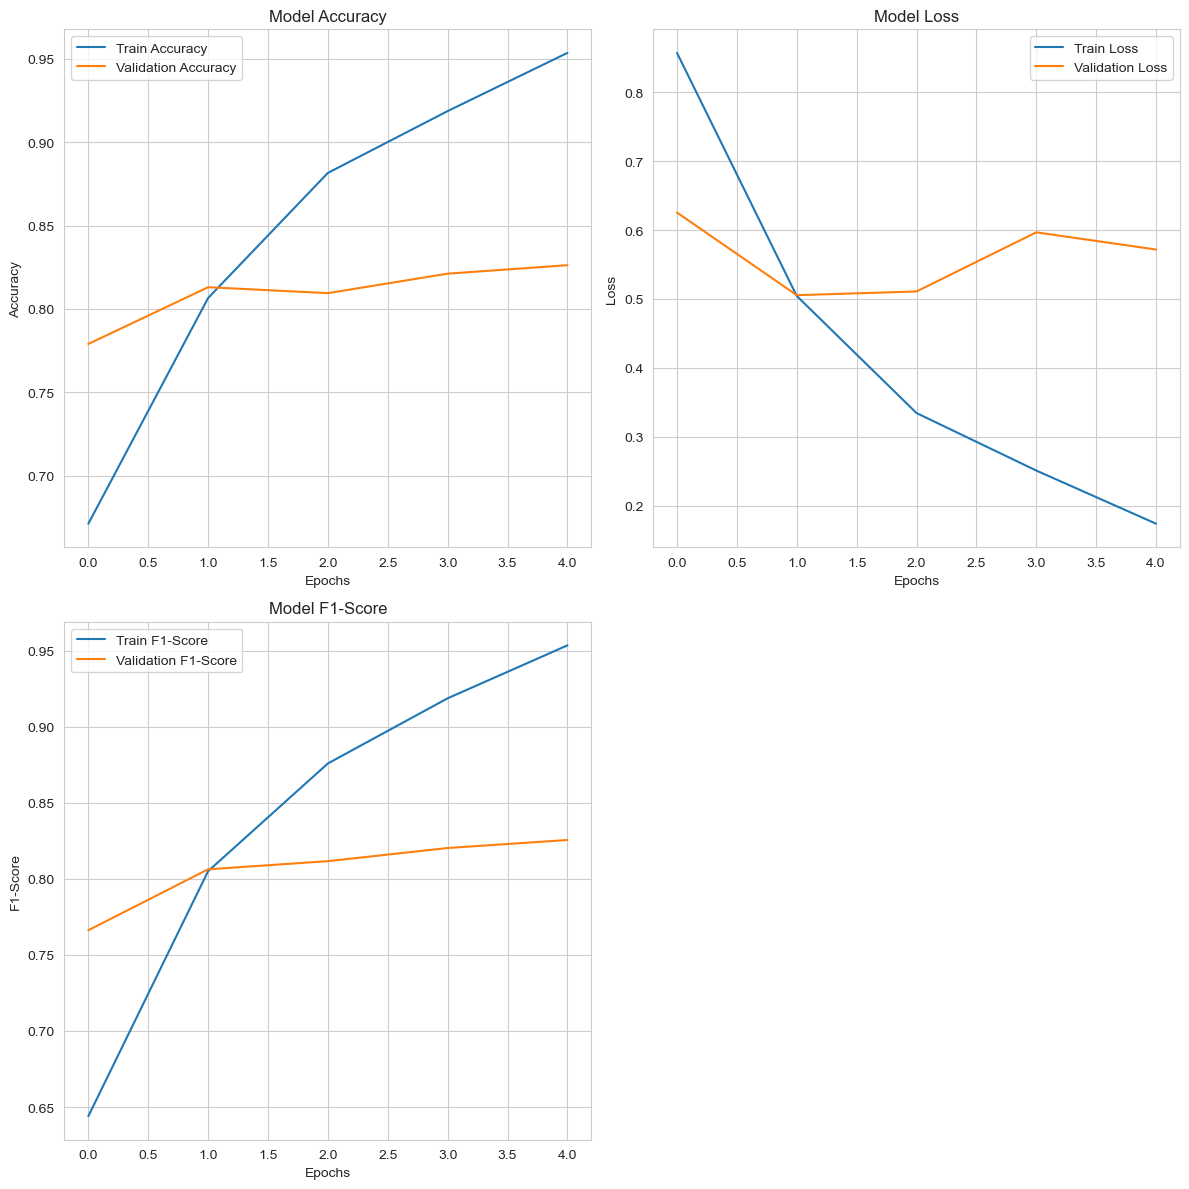

In [113]:
import matplotlib.pyplot as plt

# Plot the training and validation metrics
plt.figure(figsize=(12, 12))

# Plot Accuracy
plt.subplot(2, 2, 1)
plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot F1-Score
plt.subplot(2, 2, 3)
plt.plot(history.history['f1_score'], label='Train F1-Score')
plt.plot(history.history['val_f1_score'], label='Validation F1-Score')
plt.title('Model F1-Score')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()